In [1]:
import os
import yaml
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
DATASET_PARAMS = yaml.load(open("configs/uc_infeksi/dataset.yaml"), Loader=yaml.SafeLoader)
PREPROCESSING_PARAMS = yaml.load(open("configs/uc_infeksi/preprocessing.yaml"), Loader=yaml.SafeLoader)

In [3]:
categories =  DATASET_PARAMS['CATEGORIES']

BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, DATASET_PARAMS['DATA_PATH'])

In [4]:
from src.utils import get_device, set_seed

set_seed(DATASET_PARAMS['SEED'])
DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: cuda


# Dataset

In [5]:
from src.utils import split_dataset

In [ ]:
_, _, all_limuc_df = split_dataset(DATASET_DIR, 
                                                                        ["uc"], 
                                                                        ["limuc"], 
                                                                        shuffle=False, 
                                                                        split_ratio=[0,0,1])

subdirectories: ['infeksi', 'uc']
subdirectory: infeksi
subdirectory: uc
subdirectory: infeksi\infeksi_non_spesifik
subdirectory: uc\changsu
subdirectory: uc\hyperkvasir
subdirectory: uc\limuc
subdirectory: uc\changsu\uc_1
subdirectory: uc\changsu\uc_2
subdirectory: uc\changsu\uc_3
subdirectory: uc\hyperkvasir\uc_1
subdirectory: uc\hyperkvasir\uc_2
subdirectory: uc\hyperkvasir\uc_3
subdirectory: uc\limuc\uc_1
subdirectory: uc\limuc\uc_2
subdirectory: uc\limuc\uc_3


## Inspect dataset


Original image size: (288, 352, 3)


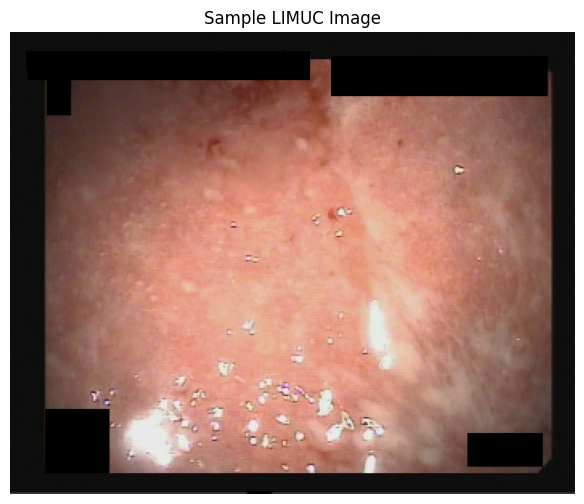

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

limuc_test_img_path = all_limuc_df[all_limuc_df['image_path'].str.contains('limuc')].iloc[1]['image_path']
img = cv2.imread(limuc_test_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f"Original image size: {img.shape}")
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title('Sample LIMUC Image')
plt.axis('off')
plt.show()


In [8]:
import cv2
import numpy as np

def safe_crop_resize(image, crop_margin=20, target_size=(299, 299), x_offset=0, y_offset=0):
    """
    Crop fixed margin from image, shift center using (x_offset, y_offset),
    and return fixed-size crop with padding if necessary.

    Args:
        image (np.ndarray): Input image.
        crop_margin (int): Margin to remove from all sides before cropping.
        target_size (tuple): Output size (width, height).
        x_offset (int): Horizontal shift of crop center (+right, -left).
        y_offset (int): Vertical shift of crop center (+down, -up).

    Returns:
        np.ndarray: Cropped and resized image.
    """
    h, w = image.shape[:2]
    img_cropped = image[crop_margin:h - crop_margin, crop_margin:w - crop_margin]
    ch, cw = img_cropped.shape[:2]

    # New center
    cx = cw // 2 + x_offset
    cy = ch // 2 + y_offset

    # Target crop size
    tw, th = target_size

    # Coordinates of the crop box
    x1 = cx - tw // 2
    x2 = x1 + tw
    y1 = cy - th // 2
    y2 = y1 + th

    # Pad if the crop box goes out of bounds
    pad_left = max(0, -x1)
    pad_top = max(0, -y1)
    pad_right = max(0, x2 - cw)
    pad_bottom = max(0, y2 - ch)

    img_padded = cv2.copyMakeBorder(
        img_cropped,
        top=pad_top,
        bottom=pad_bottom,
        left=pad_left,
        right=pad_right,
        borderType=cv2.BORDER_REFLECT_101
    )

    # Adjust coordinates after padding
    x1 += pad_left
    x2 += pad_left
    y1 += pad_top
    y2 += pad_top

    img_final_crop = img_padded[y1:y2, x1:x2]

    return img_final_crop

In [9]:
def plot_crop_preview(image, crop_margin=1, target_size=(224, 224), x_offset=-2, y_offset=13):
    """
    Plot the original image with crop box overlay and the resulting cropped image.

    Args:
        image (np.ndarray): Input image.
        crop_margin (int): Margin to crop from all sides before cropping.
        target_size (tuple): Size of the final cropped output.
        x_offset (int): Horizontal offset from image center.
        y_offset (int): Vertical offset from image center.
    """
    # Step 1: Apply cropping
    cropped = safe_crop_resize(image, crop_margin, target_size, x_offset, y_offset)

    # Step 2: Prepare original image with box overlay
    image_with_box = image.copy()
    h, w = image.shape[:2]
    img_cropped = image[crop_margin:h - crop_margin, crop_margin:w - crop_margin]
    ch, cw = img_cropped.shape[:2]

    # Calculate crop center
    cx = cw // 2 + x_offset
    cy = ch // 2 + y_offset
    tw, th = target_size
    x1 = crop_margin + cx - tw // 2
    y1 = crop_margin + cy - th // 2
    x2 = x1 + tw
    y2 = y1 + th

    # Draw rectangle on original image
    cv2.rectangle(image_with_box, (x1, y1), (x2, y2), (255, 0, 0), thickness=3)

    # Step 3: Plot side by side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_with_box)
    plt.title('Original Image with Crop Box')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cropped)
    plt.title('Cropped Output')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

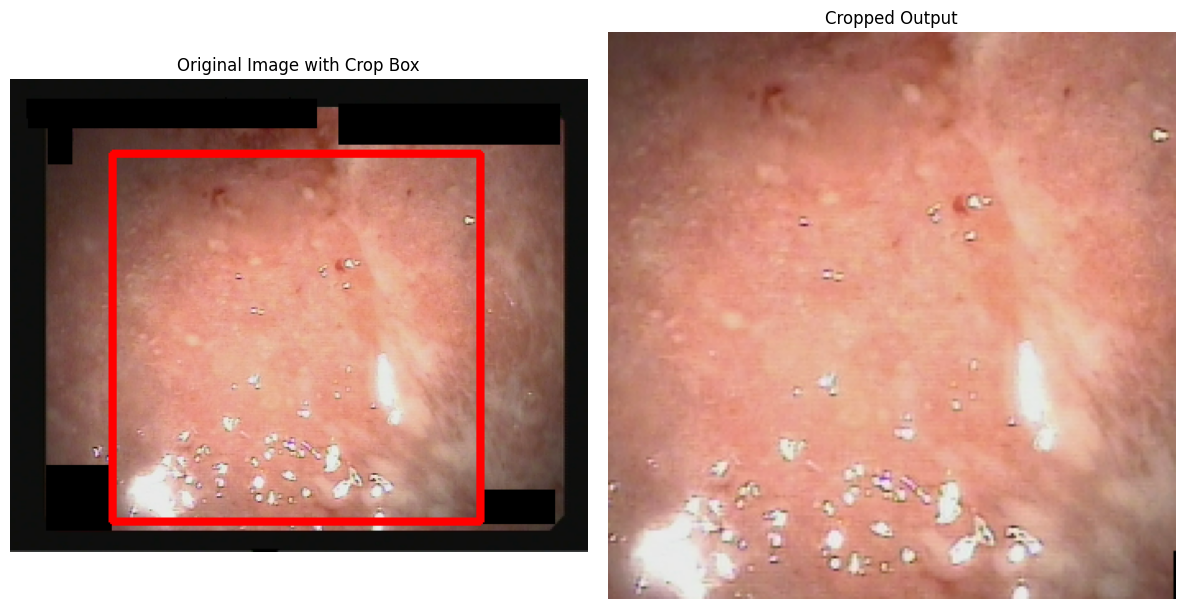

In [10]:
cropped_img = plot_crop_preview(img)

In [11]:
SAVE_DIR = "datasets/uc/limuc_cropped"

In [13]:
import cv2
import os
os.makedirs(SAVE_DIR, exist_ok=True)
from tqdm import tqdm
loop = tqdm(range(len(all_limuc_df[all_limuc_df['image_path'].str.contains('limuc')])), desc="Processing LIMUC images")
for i in loop:
    img_path = all_limuc_df[all_limuc_df['image_path'].str.contains('limuc')].iloc[i]['image_path']
    img = cv2.imread(img_path)
    cropped_img = safe_crop_resize(img, crop_margin=1, target_size=(224, 224), x_offset=-2, y_offset=13)
    cv2.imwrite(f"{SAVE_DIR}/{i}.jpg", cropped_img)

Processing LIMUC images: 100%|██████████| 1869/1869 [00:10<00:00, 174.15it/s]
